# Vibration modes of a membrane in parabolic coordinates

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from scipy.linalg import eigh
from sympy import (symbols, lambdify, init_printing,
                   expand, Matrix, diff, integrate)
from sympy.utilities.lambdify import lambdify
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
x, y, r, s= symbols('x y r s')
init_printing()

## Boundary conditions

The boundary conditions are satisfied multiplying by $b(x, y)$.

In [4]:
b = lambda x, y: (2*y - x**2 + 1)*(2*y - 1 + x**2)
bound = b(x, y)

In [5]:
b_num = lambdify((x,y), bound, "numpy")
X, Y = np.mgrid[-1:1:200j, -0.5:0.5:200j]
bound_num = b_num(X,Y)

<IPython.core.display.Javascript object>


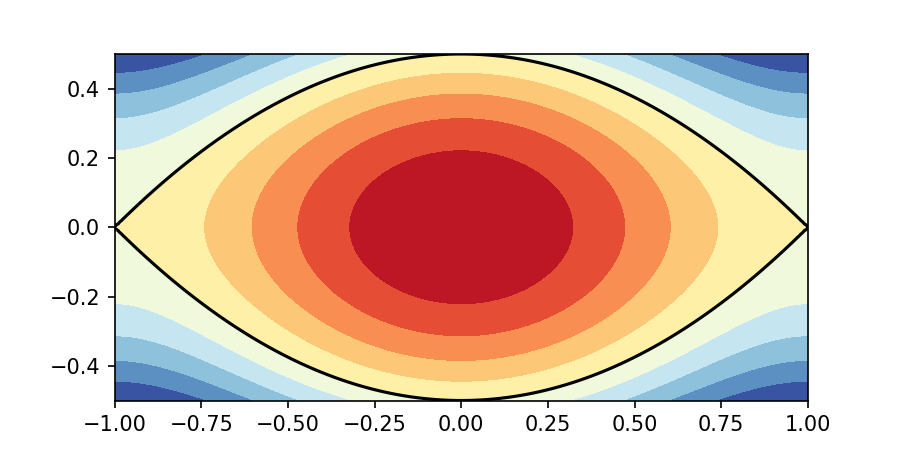

In [6]:
fig = plt.figure(figsize=(6, 3))
plt.contourf(X, Y, bound_num, 12, cmap="RdYlBu", vmin=-1, vmax=1)
plt.contour(X, Y, bound_num, [0], colors="black")
plt.axis("image");

## Approximating functions

In [7]:
def w_fun(x, y, m, n):
    """ Trial function. """
    c = symbols('c:%d' % (m*n)) # This is the way of define the coefficients c_i
    w = []
    for i in range(0, m):
        for j in range(0, n):
            w.append(x**i * y**j)
    
    return w, c

def u_fun(x, y, m, n):
    """ Complete function. Contains the boundary and trial functions. """
    w, c = w_fun(x, y, m, n)
    return [b(x, y) * phi for phi in w ], c

m = 10
n = 9
u, c = u_fun(x, y, m, n)

## Matrices and solution

In [8]:
dudx = [diff(u[k], x) for k in range(len(c))]
dudy = [diff(u[k], y) for k in range(len(c))]

In [9]:
Kaux = Matrix(m*n, m*n, lambda ii, jj: dudx[ii]*dudx[jj] + dudy[ii]*dudy[jj])
Maux = Matrix(m*n, m*n, lambda ii, jj: u[ii]*u[jj])
K = Matrix(m*n, m*n, lambda i,j: 0)
M = Matrix(m*n, m*n, lambda i,j: 0)

The integrals should be of the form

$$B_{ij} = \int\limits_{-1}^1\int\limits_{\frac{1}{2}(x^2 - 1)}^{\frac{1}{2}(1 - x^2)}
  A_{ij} \mathrm{d}y\, \mathrm{d}x\, ,$$

In [10]:
for row in range(m*n):
    for col in range(row, m*n):
        K_inte = Kaux[row, col]
        M_inte = Maux[row, col]
        K_inte = integrate(K_inte, (y, (x**2 - 1)/2, (1 - x**2)/2), (x, -1, 1))
        M_inte = integrate(M_inte, (y, (x**2 - 1)/2, (1 - x**2)/2), (x, -1, 1))
        K[row, col] += K_inte
        M[row, col] += M_inte
        if row != col:
            K[col, row] += K_inte
            M[col, row] += M_inte

In [11]:
Kn = np.array(K).astype(np.float64)
Mn = np.array(M).astype(np.float64)

In [12]:
vals, vecs = eigh(Kn, Mn, eigvals=(0,8))
vals

array([ 16.10095349,  30.93334613,  50.33837571,  50.33838703,
        74.38718728,  74.38735248, 102.69815051, 102.75135697,
       105.00010187])

## Visualization of the modes

In [13]:
mask = np.ones_like(X)
mask[bound_num > 0] = np.nan

<IPython.core.display.Javascript object>


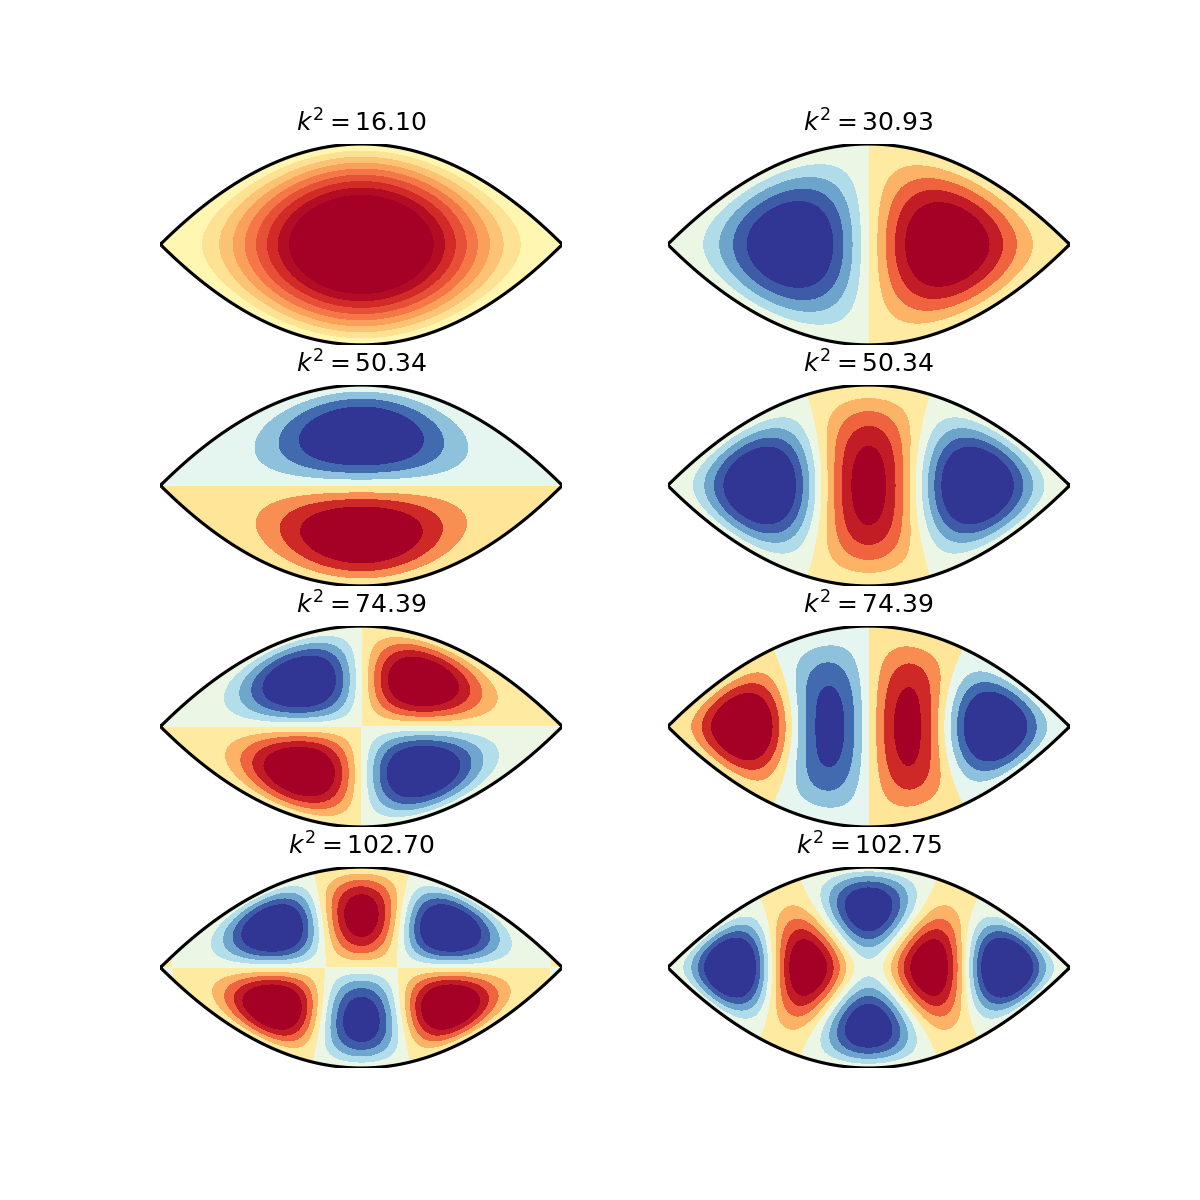

In [14]:
plt.figure(figsize=(8, 8))
for i in range(8):
    U = sum(vecs[j, i]*u[j] for j in range(m*n))
    vecU = lambdify((x,y), U, "numpy")
    Z = vecU(X,Y)*mask
    Z_max = Z.max()
    Z_max = max (Z_max, -Z.min())
    plt.subplot(4, 2, i + 1)
    plt.title(r"$k^2=%.2f$" % vals[i], size=12);
    plt.contour(X, Y, bound_num, [0], colors="black")
    plt.contourf(X, Y, Z, 12, cmap="RdYlBu", vmin=-1.2, vmax=1.2)
    plt.axis("image")
    plt.axis(False)
plt.savefig("../../../Documents/%dx%d.png" % (m, n), dpi=300)

## Analytic mass matrix

The mass matrix can be integrated analytically.

In [15]:
from sympy import gamma

def mass_coeff(j, k, m, n):
    coeff = (k + n + 2)*(k + n + 4)*(1 + (-1)**(j + m))*(1 + (-1)**(k + n))
    coeff *= gamma(n + k + 1)*gamma((1 + m + j)/2)/gamma((13 + m + j + 2*n + 2*k)/2)
    coeff /= 2**(k + n - 1)
    return coeff

In [16]:
mass_coeff(0, 0, 0, 0)

In [20]:
vals

array([ 16.10095349,  30.93334613,  50.33837571,  50.33838703,
        74.38718728,  74.38735248, 102.69815051, 102.75135697,
       105.00010187])